In [1]:
import os

In [2]:
import copy
import pathlib

import gymnasium as gym
import numpy as np
import torch
import torchvision
from lightning.fabric import Fabric
from omegaconf import OmegaConf
from PIL import Image

from sheeprl.algos.dreamer_v3.agent import build_agent
from sheeprl.data.buffers import SequentialReplayBuffer
from sheeprl.utils.env import make_env
from sheeprl.utils.utils import dotdict
from sheeprl.algos.p2e_dv3_ppo.agent import build_agent
from sheeprl.algos.p2e_dv3_ppo.agent import PPOAgent
from sheeprl.algos.dreamer_v3.utils import Moments, compute_lambda_values, prepare_obs, test
from datetime import datetime

/home/calm04/miniconda3/envs/sheeprl/lib/python3.10/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


In [3]:
import os
import warnings
from typing import Any, Callable, Dict, Optional

import cv2
import gymnasium as gym
import hydra
import numpy as np

from sheeprl.envs.wrappers import (
    ActionRepeat,
    ActionsAsObservationWrapper,
    FrameStack,
    GrayscaleRenderWrapper,
    MaskVelocityWrapper,
    RewardAsObservationWrapper,
)
from sheeprl.utils.imports import _IS_DIAMBRA_ARENA_AVAILABLE, _IS_DIAMBRA_AVAILABLE, _IS_DMC_AVAILABLE

if _IS_DIAMBRA_ARENA_AVAILABLE and _IS_DIAMBRA_AVAILABLE:
    from sheeprl.envs.diambra import DiambraWrapper
if _IS_DMC_AVAILABLE:
    pass

In [4]:
ckpt_path = "/home/calm04/data/sheeprl/logs/runs/p2e_dv3_exploration_ppo/MsPacman-v4/2024-08-11_19-02-55_p2e_dv3_exploration_ppo_MsPacman-v4_42/version_0/checkpoint/ckpt_40448_0.ckpt"
ckpt_path = pathlib.Path(ckpt_path)

In [5]:
seed = 5
fabric = Fabric(accelerator="cuda", devices=1)
fabric.launch()
state = fabric.load(ckpt_path)
cfg = dotdict(OmegaConf.to_container(OmegaConf.load(ckpt_path.parent.parent / "config.yaml"), resolve=True))

# The number of environments is set to 1
cfg.env.num_envs = 1

/home/calm04/miniconda3/envs/sheeprl/lib/python3.10/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [6]:
cfg.checkpoint.resume_from = True

In [7]:
from gym.wrappers import RecordVideo
from gym.wrappers.monitoring.video_recorder import VideoRecorder

In [8]:
from gym.wrappers import RecordVideo

class CustomRecordVideo(RecordVideo):
    def close(self):
        
        if self.video_recorder is not None and not self.video_recorder.functional:
            self.video_recorder.close()
            self.video_recorder = None
        super().close()

In [9]:
def make_env(
    cfg: Dict[str, Any],
    seed: int,
    rank: int,
    run_name: Optional[str] = None,
    prefix: str = "",
    vector_env_idx: int = 0,
) -> Callable[[], gym.Env]:
    """
    Create the callable function to create environment and
    force the environment to return an observation space of type
    gymnasium.spaces.Dict.

    Args:
        cfg (Dict[str, Any]): the configs of the environment to initialize.
        seed (int): the seed to use.
        rank (int): the rank of the process.
        run_name (str, optional): the name of the run.
            Default to None.
        prefix (str): the prefix to add to the video folder.
            Default to "".
        vector_env_idx (int): the index of the environment.

    Returns:
        The callable function that initializes the environment.
    """

    def thunk() -> gym.Env:
        try:
            env_spec = gym.spec(cfg.env.id).entry_point
        except Exception:
            env_spec = ""

        if "diambra" in cfg.env.wrapper._target_ and not cfg.env.sync_env:
            if cfg.env.wrapper.diambra_settings.pop("splash_screen", True):
                warnings.warn(
                    "You must set the `splash_screen` setting to `False` when using the `AsyncVectorEnv` "
                    "in `DIAMBRA` environments. The specified `splash_screen` setting is ignored and set "
                    "to `False`."
                )
            cfg.env.wrapper.diambra_settings.splash_screen = False

        instantiate_kwargs = {}
        if "seed" in cfg.env.wrapper:
            instantiate_kwargs["seed"] = seed
        if "rank" in cfg.env.wrapper:
            instantiate_kwargs["rank"] = rank + vector_env_idx
        if "unity_env" in cfg.env.wrapper._target_:
            env = hydra.utils.instantiate(cfg.env.wrapper, **instantiate_kwargs, _convert_="all", env_num_id=vector_env_idx)
        else:
            env = hydra.utils.instantiate(cfg.env.wrapper, **instantiate_kwargs, _convert_="all")


        # action repeat
        if (
            cfg.env.action_repeat > 1
            and "atari" not in env_spec
            and (not (_IS_DIAMBRA_ARENA_AVAILABLE and _IS_DIAMBRA_AVAILABLE) or not isinstance(env, DiambraWrapper))
        ):
            env = ActionRepeat(env, cfg.env.action_repeat)

        if "mask_velocities" in cfg.env and cfg.env.mask_velocities:
            env = MaskVelocityWrapper(env)

        if not (
            isinstance(cfg.algo.mlp_keys.encoder, list)
            and isinstance(cfg.algo.cnn_keys.encoder, list)
            and len(cfg.algo.cnn_keys.encoder + cfg.algo.mlp_keys.encoder) > 0
        ):
            raise ValueError(
                "`algo.cnn_keys.encoder` and `algo.mlp_keys.encoder` must be lists of strings, got: "
                f"cnn encoder keys `{cfg.algo.cnn_keys.encoder}` of type `{type(cfg.algo.cnn_keys.encoder)}` "
                f"and mlp encoder keys `{cfg.algo.mlp_keys.encoder}` of type `{type(cfg.algo.mlp_keys.encoder)}`. "
                "Both must be non-empty lists."
            )

        # Create observation dict
        encoder_cnn_keys_length = len(cfg.algo.cnn_keys.encoder)
        encoder_mlp_keys_length = len(cfg.algo.mlp_keys.encoder)
        if isinstance(env.observation_space, gym.spaces.Box) and len(env.observation_space.shape) < 2:
            # Vector only observation
            if encoder_cnn_keys_length > 0:
                if encoder_cnn_keys_length > 1:
                    warnings.warn(
                        "Multiple cnn keys have been specified and only one pixel observation "
                        f"is allowed in {cfg.env.id}, "
                        f"only the first one is kept: {cfg.algo.cnn_keys.encoder[0]}"
                    )
                if encoder_mlp_keys_length > 0:
                    gym.wrappers.pixel_observation.STATE_KEY = cfg.algo.mlp_keys.encoder[0]
                env = gym.wrappers.PixelObservationWrapper(
                    env, pixels_only=encoder_mlp_keys_length == 0, pixel_keys=(cfg.algo.cnn_keys.encoder[0],)
                )
            else:
                if encoder_mlp_keys_length > 1:
                    warnings.warn(
                        "Multiple mlp keys have been specified and only one pixel observation "
                        f"is allowed in {cfg.env.id}, "
                        f"only the first one is kept: {cfg.algo.mlp_keys.encoder[0]}"
                    )
                mlp_key = cfg.algo.mlp_keys.encoder[0]
                env = gym.wrappers.TransformObservation(env, lambda obs: {mlp_key: obs})
                env.observation_space = gym.spaces.Dict({mlp_key: env.observation_space})
        elif isinstance(env.observation_space, gym.spaces.Box) and 2 <= len(env.observation_space.shape) <= 3:
            # Pixel only observation
            if encoder_cnn_keys_length > 1:
                warnings.warn(
                    "Multiple cnn keys have been specified and only one pixel observation "
                    f"is allowed in {cfg.env.id}, "
                    f"only the first one is kept: {cfg.algo.cnn_keys.encoder[0]}"
                )
            elif encoder_cnn_keys_length == 0:
                raise ValueError(
                    "You have selected a pixel observation but no cnn key has been specified. "
                    "Please set at least one cnn key in the config file: `algo.cnn_keys.encoder=[your_cnn_key]`"
                )
            cnn_key = cfg.algo.cnn_keys.encoder[0]
            env = gym.wrappers.TransformObservation(env, lambda obs: {cnn_key: obs})
            env.observation_space = gym.spaces.Dict({cnn_key: env.observation_space})

        if (
            len(
                set(k for k in env.observation_space.keys()).intersection(
                    set(cfg.algo.mlp_keys.encoder + cfg.algo.cnn_keys.encoder)
                )
            )
            == 0
        ):
            raise ValueError(
                f"The user specified keys `{cfg.algo.mlp_keys.encoder + cfg.algo.cnn_keys.encoder}` "
                "are not a subset of the "
                f"environment `{env.observation_space.keys()}` observation keys. Please check your config file."
            )

        env_cnn_keys = set(
            [k for k in env.observation_space.spaces.keys() if len(env.observation_space[k].shape) in {2, 3}]
        )
        cnn_keys = env_cnn_keys.intersection(set(cfg.algo.cnn_keys.encoder))

        def transform_obs(obs: Dict[str, Any]):
            for k in cnn_keys:
                current_obs = obs[k]
                shape = current_obs.shape
                is_3d = len(shape) == 3
                is_grayscale = not is_3d or shape[0] == 1 or shape[-1] == 1
                channel_first = not is_3d or shape[0] in (1, 3)

                # to 3D image
                if not is_3d:
                    current_obs = np.expand_dims(current_obs, axis=0)

                # channel last (opencv needs it)
                if channel_first:
                    current_obs = np.transpose(current_obs, (1, 2, 0))

                # resize
                if current_obs.shape[:-1] != (cfg.env.screen_size, cfg.env.screen_size):
                    current_obs = cv2.resize(
                        current_obs, (cfg.env.screen_size, cfg.env.screen_size), interpolation=cv2.INTER_AREA
                    )

                # to grayscale
                if cfg.env.grayscale and not is_grayscale:
                    current_obs = cv2.cvtColor(current_obs, cv2.COLOR_RGB2GRAY)

                # back to 3D
                if len(current_obs.shape) == 2:
                    current_obs = np.expand_dims(current_obs, axis=-1)
                    if not cfg.env.grayscale:
                        current_obs = np.repeat(current_obs, 3, axis=-1)

                # channel first (PyTorch default)
                obs[k] = current_obs.transpose(2, 0, 1)

            return obs

        env = gym.wrappers.TransformObservation(env, transform_obs)
        for k in cnn_keys:
            env.observation_space[k] = gym.spaces.Box(
                0, 255, (1 if cfg.env.grayscale else 3, cfg.env.screen_size, cfg.env.screen_size), np.uint8
            )

        if cnn_keys is not None and len(cnn_keys) > 0 and cfg.env.frame_stack > 1:
            if cfg.env.frame_stack_dilation <= 0:
                raise ValueError(
                    f"The frame stack dilation argument must be greater than zero, got: {cfg.env.frame_stack_dilation}"
                )
            env = FrameStack(env, cfg.env.frame_stack, cnn_keys, cfg.env.frame_stack_dilation)

        if cfg.env.actions_as_observation.num_stack > 0 and "diambra" not in cfg.env.wrapper._target_:
            env = ActionsAsObservationWrapper(env, **cfg.env.actions_as_observation)

        if cfg.env.reward_as_observation:
            env = RewardAsObservationWrapper(env)

        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        if cfg.env.max_episode_steps and cfg.env.max_episode_steps > 0:
            env = gym.wrappers.TimeLimit(env, max_episode_steps=cfg.env.max_episode_steps)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        if cfg.env.capture_video and rank == 0 and vector_env_idx == 0 and run_name is not None:
            if cfg.env.grayscale:
                env = GrayscaleRenderWrapper(env)
            env = CustomRecordVideo(env, video_folder="./videos",
                                    name_prefix=f"episode_{seed}",
                                    )

            # Atari 환경에 대한 기본 FPS 설정
            if "AtariEnv" in str(type(env.unwrapped)):
                env.metadata["render_fps"] = cfg.env.get("atari_fps", 60)  # 기본값 60 또는 설정에서 가져온 값
            elif hasattr(env, 'frames_per_sec'):
                env.metadata["render_fps"] = env.frames_per_sec
            else:
                env.metadata["render_fps"] = cfg.env.get("default_fps", 30)  # 기본값 30 또는 설정에서 가져온 값
        return env

    return thunk

In [10]:
envs = gym.vector.SyncVectorEnv(
    [
        make_env(
            cfg,
            cfg.seed + 0 * cfg.env.num_envs + i,
            0 * cfg.env.num_envs,
            "./imagination",
            "imagination",
            vector_env_idx=i,
        )
        for i in range(cfg.env.num_envs)
    ]
)
action_space = envs.single_action_space
observation_space = envs.single_observation_space
obs_keys = cfg.algo.cnn_keys.encoder + cfg.algo.mlp_keys.encoder

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/home/calm04/miniconda3/envs/sheeprl/lib/python3.10/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /media/hdd2/calm04/sheeprl/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [11]:
is_continuous = isinstance(action_space, gym.spaces.Box)
is_multidiscrete = isinstance(action_space, gym.spaces.MultiDiscrete)
actions_dim = tuple( 
    action_space.shape if is_continuous else (action_space.nvec.tolist() if is_multidiscrete else [action_space.n])
)

In [12]:
state['actor_task'].keys()

odict_keys(['actor.model._model.0.weight', 'actor.model._model.1.weight', 'actor.model._model.1.bias', 'actor.model._model.3.weight', 'actor.model._model.4.weight', 'actor.model._model.4.bias', 'actor.model._model.6.weight', 'actor.model._model.7.weight', 'actor.model._model.7.bias', 'actor.model._model.9.weight', 'actor.model._model.10.weight', 'actor.model._model.10.bias', 'actor.model._model.12.weight', 'actor.model._model.13.weight', 'actor.model._model.13.bias', 'actor.mlp_heads.0.weight', 'actor.mlp_heads.0.bias', 'critic._model.0.weight', 'critic._model.0.bias', 'critic._model.1.weight', 'critic._model.1.bias', 'critic._model.3.weight', 'critic._model.3.bias', 'critic._model.4.weight', 'critic._model.4.bias', 'critic._model.6.weight', 'critic._model.6.bias', 'critic._model.7.weight', 'critic._model.7.bias', 'critic._model.9.weight', 'critic._model.9.bias', 'critic._model.10.weight', 'critic._model.10.bias', 'critic._model.12.weight', 'critic._model.12.bias', 'critic._model.13.we

In [13]:
(
    world_model,
    ensembles,
    ppo_agent,
    player,
) = build_agent(
    fabric,
    actions_dim,
    is_continuous,
    cfg,
    observation_space,
    state["world_model"] if cfg.checkpoint.resume_from else None,
    state["ensembles"] if cfg.checkpoint.resume_from else None,
    state["actor_task"] if cfg.checkpoint.resume_from else None,
)

INFO:pytorch_lightning.utilities.rank_zero:Fabric will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Fabric(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:Fabric will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Fabric(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: Seed set to 43
INFO:lightning.fabric.utilities.seed:Seed set to 43
INFO: Seed set to 44
INFO:lightning.fabric.utilities.seed:Seed set to 44
INFO: Seed set to 45
INFO:lightning.fabric.utilities.seed:Seed set to 45


In [14]:
# 환경 초기화
obs, _ = envs.reset(seed=seed)

In [15]:
step_data = {}
for k in obs_keys:
    step_data[k] = obs[k][np.newaxis]
player.init_states()

In [16]:
# # 환경 초기화
# obs, _ = envs.reset(seed=seed)

# # Inference 루프
# total_reward = 0
# done = False
# episode_length = 0

# while not done:
#     with torch.no_grad():
#         # 관찰을 준비
#         torch_obs = prepare_obs(fabric, obs, cnn_keys=cfg.algo.cnn_keys.encoder, num_envs=cfg.env.num_envs)
#         mask = {k: v for k, v in torch_obs.items() if k.startswith("mask")}
#         if len(mask) == 0:
#             mask = None
        
#         # 액션 선택
#         real_actions = actions = player.get_actions(torch_obs, mask=mask)
#         actions = torch.cat(actions, -1).cpu().numpy()
#         if is_continuous:
#             real_actions = torch.stack(real_actions, dim=-1).cpu().numpy()
#         else:
#             real_actions = torch.stack([real_act.argmax(dim=-1) for real_act in real_actions], dim=-1).cpu().numpy()

#         # 환경 스텝 실행
#         next_obs, reward, terminated, truncated, info = envs.step(real_actions.reshape(envs.action_space.shape))
        
#         total_reward += reward[0]  # 단일 환경이므로 첫 번째 요소만 사용
#         episode_length += 1
        
#         # 종료 조건 확인
#         done = terminated[0] or truncated[0]
        
#         # 다음 스텝을 위해 obs 업데이트
#         obs = next_obs

# print(f"Episode finished. Total reward: {total_reward}, Length: {episode_length}")

# envs.close()

In [17]:
import torch
import torchvision.transforms.functional as TF
from PIL import Image

# 환경 초기화
obs, _ = envs.reset(seed=seed)

# Inference 루프
total_reward = 0
done = False
episode_length = 0
frames = []  # GIF를 만들기 위한 프레임 리스트

while not done:
    with torch.no_grad():
        # 관찰을 준비
        torch_obs = prepare_obs(fabric, obs, cnn_keys=cfg.algo.cnn_keys.encoder, num_envs=cfg.env.num_envs)
        mask = {k: v for k, v in torch_obs.items() if k.startswith("mask")}
        if len(mask) == 0:
            mask = None
        
        embedded_obs = player.encoder(torch_obs)
        recurrent_state = player.rssm.recurrent_model(
            torch.cat((player.stochastic_state, player.actions), -1), player.recurrent_state
        )
        _, stochastic_state = player.rssm._representation(recurrent_state, embedded_obs)
        stochastic_state = stochastic_state.view(
            *stochastic_state.shape[:-2], player.stochastic_size * player.discrete_size
        )
        
        # `latent_state`는 `stochastic_state`와 `recurrent_state`의 결합
        latent_state = torch.cat((stochastic_state, recurrent_state), -1)
        
        # 잠재 상태를 사용하여 이미지 재구성
        reconstructed_obs = world_model.observation_model(latent_state)
        # reconstructed_img = torch.clamp(reconstructed_obs['rgb'][0], 0, 1).squeeze(0)
        reconstructed_img = torch.clamp(reconstructed_obs['rgb'][0] + 0.5, 0, 1).squeeze(0)        
        frames.append(TF.to_pil_image(reconstructed_img))
        
        real_actions = actions = player.get_actions(torch_obs, mask=mask)
        actions = torch.cat(actions, -1).cpu().numpy()
        if is_continuous:
            real_actions = torch.stack(real_actions, dim=-1).cpu().numpy()
        else:
            real_actions = torch.stack([real_act.argmax(dim=-1) for real_act in real_actions], dim=-1).cpu().numpy()
            
        next_obs, reward, terminated, truncated, info = envs.step(real_actions.reshape(envs.action_space.shape))
        
        total_reward += reward[0]  # 단일 환경이므로 첫 번째 요소만 사용
        episode_length += 1
        
        # 종료 조건 확인
        done = terminated[0] or truncated[0]
        
        # 다음 스텝을 위해 obs 업데이트
        obs = next_obs

envs.close()

# GIF로 저장
frame_one = frames[0]
frame_one.save("reconstructed_obs.gif", format="GIF", append_images=frames, save_all=True, duration=100, loop=0)

Moviepy - Building video /media/hdd2/calm04/sheeprl/videos/episode_42-episode-0.mp4.
Moviepy - Writing video /media/hdd2/calm04/sheeprl/videos/episode_42-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /media/hdd2/calm04/sheeprl/videos/episode_42-episode-0.mp4
Moviepy - Building video /media/hdd2/calm04/sheeprl/videos/episode_42-episode-1.mp4.
Moviepy - Writing video /media/hdd2/calm04/sheeprl/videos/episode_42-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /media/hdd2/calm04/sheeprl/videos/episode_42-episode-1.mp4


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Loading "original-fs" failed
Error: Cannot find module 'original-fs'
Require stack:
- /home/calm04/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js
    at Module._resolveFilename (node:internal/modules/cjs/loader:1145:15)
    at Module._load (node:internal/modules/cjs/loader:986:27)
    at Module.require (node:internal/modules/cjs/loader:1233:19)
    at require (node:internal/modules/helpers:179:18)
    at i (/home/calm04/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js:3:98)
    at r.load (/home/calm04/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js:2:1637)
    at h.load (/home/calm04/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js:1:13958)
    at u (/ho

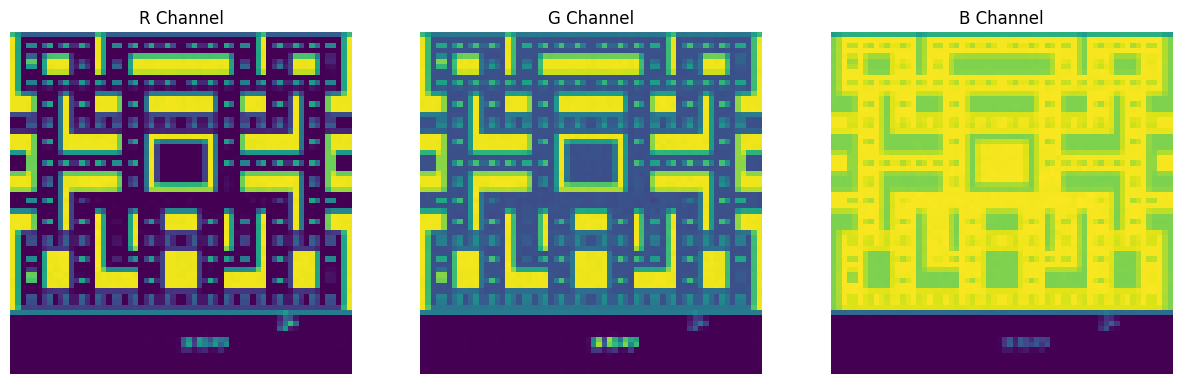

In [18]:
import matplotlib.pyplot as plt

# 이미지 확인 (PIL로 시각화)
reconstructed_img_pil = TF.to_pil_image(reconstructed_img)
reconstructed_img_pil.show()  # 바로 이미지를 열어 확인

# 또는 Matplotlib로 채널별 시각화
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
channels = ['R', 'G', 'B']
for i, ax in enumerate(axs):
    ax.imshow(reconstructed_img[i].cpu().numpy())
    ax.set_title(f'{channels[i]} Channel')
    ax.axis('off')
plt.show()

In [19]:
reconstructed_obs['rgb'][0].shape

torch.Size([1, 3, 64, 64])